In [1]:
import os
import pickle

import tensorflow as tf
from keras.callbacks import *

from data_loader import *
from model import *
from my_metrics import *

import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
'''
訓練跟驗證集的原圖與標籤增生
可以將trainGenerator函式中save_to_dir改到自己指定資料夾, 就能看到增生的圖像與標籤
例如 save_to_dir=r"data\membrane\train\aug"
'''

data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode="nearest")

myGene = train_generator(16, "data/membrane/train", "image", "label", data_gen_args, save_to_dir=None)

val_aug_dict = {"rescale": 1./255}

valGene = train_generator(16, "data/membrane/val", "val_image", "val_label", val_aug_dict,
                         image_color_mode="grayscale", mask_color_mode="grayscale",
                         image_save_prefix="val_image", mask_save_prefix="val_label",
                         save_to_dir=None, target_size=(256, 256), seed=1)

In [4]:
model = residual_attention_unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 256, 1)  0           ['batch_normalization[0][0]']    
                                                                                              

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=dice_loss, metrics=[iou_coefficient, dice_coefficient, "accuracy"])

model_checkpoint = ModelCheckpoint("best_model.hdf5", monitor="loss", verbose=1, save_best_only=True)

#每個時期迭代次數 = 資料夾圖片總數 / 訓練批次(batch_size)
history = model.fit(myGene, epochs=100, steps_per_epoch=78, validation_data=valGene, validation_steps=23,
                    callbacks=[model_checkpoint])

Found 1245 images belonging to 1 classes.
Found 1245 images belonging to 1 classes.
Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.0585 - iou_coefficient: 0.8919 - dice_coefficient: 0.9416 - accuracy: 0.9255Found 357 images belonging to 1 classes.
Found 357 images belonging to 1 classes.

Epoch 1: loss improved from inf to 0.05846, saving model to best_model.hdf5
78/78 [==============================] - 39s 359ms/step - loss: 0.0585 - iou_coefficient: 0.8919 - dice_coefficient: 0.9416 - accuracy: 0.9255 - val_loss: 0.1317 - val_iou_coefficient: 0.7670 - val_dice_coefficient: 0.8681 - val_accuracy: 0.8220
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.0299 - iou_coefficient: 0.9419 - dice_coefficient: 0.9701 - accuracy: 0.9536
Epoch 2: loss improved from 0.05846 to 0.02994, saving model to best_model.hdf5
78/78 [==============================] - 20s 258ms/step - loss: 0.0299 - iou_coefficient: 0.9419 - dice_coefficient: 0.9701 - accuracy: 

In [6]:
#保存訓練指標
with open("trainHistory.txt", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

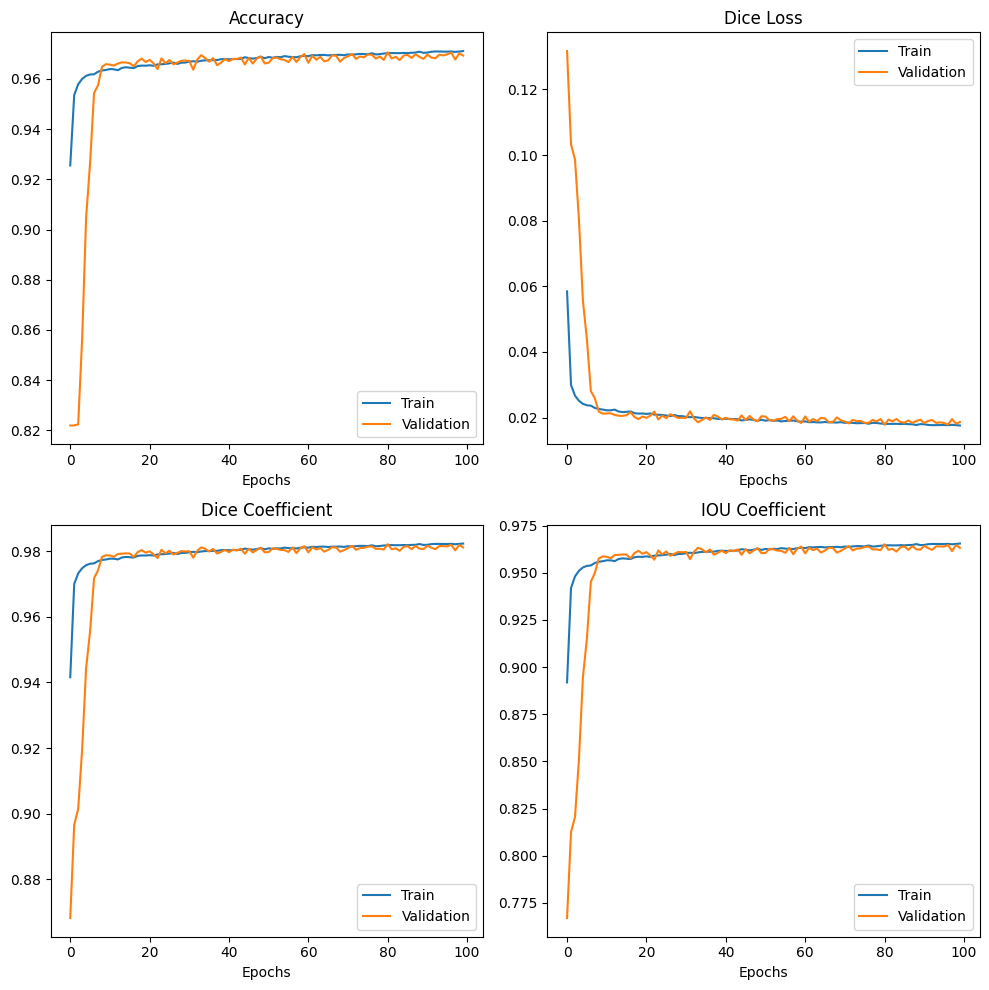

In [7]:
#訓練指標視覺化
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history.history["accuracy"], label="Train")
axs[0, 0].plot(history.history["val_accuracy"], label="Validation")
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].legend()

axs[0, 1].plot(history.history["loss"], label="Train")
axs[0, 1].plot(history.history["val_loss"], label="Validation")
axs[0, 1].set_title("Dice Loss")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].legend()

axs[1, 0].plot(history.history["dice_coefficient"], label="Train")
axs[1, 0].plot(history.history["val_dice_coefficient"], label="Validation")
axs[1, 0].set_title("Dice Coefficient")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].legend()

axs[1, 1].plot(history.history["iou_coefficient"], label="Train")
axs[1, 1].plot(history.history["val_iou_coefficient"], label="Validation")
axs[1, 1].set_title("IOU Coefficient")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [8]:
#用訓練好的模型預測測試集圖像
testGene = test_generator(r"D:\unet_ours\data\membrane\test")
model.load_weights("best_model.hdf5")
results = model.predict(testGene, 180, verbose=1)
save_result(r"D:\unet_ours\data\membrane\test", results)

180/180 [==============================] - 2s 11ms/step
